# CESM-LE analysis
### Looks at snow pack changes over time, globally
 - reading in ensemble of data from CESM2_LENS
 - here, looking at daily SNOWDP, soil temperature & runoff
 - calculations with 36 dask workers from casper tend to spill to disk
 - file IO from daniel kennedy, djk2120@ucar.edu
 - modified will wieder, wwieder@ucar.edu

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib.lines as mlines
import matplotlib.dates as mdates

import pandas as pd
import cftime
import dask
import os
from scipy import stats
%matplotlib inline

In [2]:
## was working with 16.2
xr.__version__

'0.16.2'

In [3]:
## was working with 2021.01.0
dask.__version__

'2021.01.0'

### run this cell to check if you have LENS2 read access:

In [4]:
samplefile = ('/glade/campaign/cesm/collections/CESM2-LE/archive/b.e21.BHISTcmip6.f09_g17.LE2-1001.001/'+
              'lnd/proc/tseries/month_1/b.e21.BHISTcmip6.f09_g17.LE2-1001.001.clm2.h0.NBP.199001-199912.nc')
cmd = 'stat '+samplefile
if os.system(cmd)!=0:
    print('you may not have access')
else:
    print('looks good')

looks good


### Fetch cluster

In [5]:
# For use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
# Anderson recommended "Reduce the number of dask-workers (from 36 to 18) 
#    to allow dask to allocate more memory to each worker"
# Trying to request more memory to avoid killing workings when we plot this up.

ncores = 18
nmem   = str(int(375*ncores/ncores*2))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='4:00:00')
cluster.scale(ncores)
client = Client(cluster)

In [11]:
# the extra workers can get stuck in the queue
#   stay here (rerunning cell) until you see that the workers>0
client

# If not running, check the following on command line
# squeue -u wwieder see that the job is not yet running
# cancel any orphaned workers, e.g `scancel 6444926`

Client Scheduler: tcp://10.12.205.30:40131 Dashboard: http://10.12.205.30/proxy/8787/status,Cluster Workers: 18 Cores: 18 Memory: 750.06 GB


### Some helpful functions:
 - run all these before proceeding to the start here area:
 - you can certainly edit these, but shouldn't need to

In [12]:
def get_file(ee,model,field,component,yr):
    ''' Returns a given field from ensemble number ee for either CESM1 or CESM2'''
    if model == 'CESM1':
        topdir = ('/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/'+
                  'lnd/proc/tseries/monthly/')
        matchme = 'b.e11.B20TRC5CNBDRD.f09_g16.'
        lenskey = list(1+np.arange(35))+list(101+np.arange(7))
        nn      = lenskey[ee]
        ff = glob.glob(topdir+field+'/'+matchme+str(nn).zfill(3)+'*.nc')[0]
    else:
        topdir = '/glade/campaign/cesm/collections/CESM2-LE/archive/'
        if yr<=2014:
            mlist = sorted(glob.glob(topdir+'*BHISTcmip6.f09_g17.LE2-13*')) # not all ensembles have daily data
        else:
            mlist = sorted(glob.glob(topdir+'*BSSP370cmip6.f09_g17.LE2-13*')) # hack to get SSPs
        mm = mlist[ee]
        atm    = '/atm/proc/tseries/day_1/'
        lnd    = '/lnd/proc/tseries/day_1/'
        firstyear = 10*int(yr/10)
        if yr >= 2015:  # Beause SSPs are 2015-2024...
            firstyear = 10*int(yr/10)+5
        yy    = '.'+str(firstyear)+'0101-'+str(firstyear+9)+'1231.'

        if yr>2009:
            if yr<2014:
                yy = '.20100101-20141231.'
        if yr>=2095:
            yy = '.20950101-21001231.'
        if component == 'lnd': ff = glob.glob(mm+lnd+'*.h5.'+field+yy+'*')[0]
        if component == 'atm': ff = glob.glob(mm+atm+'*.h1.'+field+yy+'*')[0]
    return ff

In [13]:
def all_files(model,field,firstyear, component,nens):
    ''' Returns all files for either CESM1 or CESM2, starting at firstyear'''
    if model == 'CESM1':
        files = [get_file(ee,'CESM1',field,component,0) for ee in range(nens)]
    else:
        if firstyear <= 2014:
            yrs = [*np.arange(firstyear,2009,10),2010]
        if firstyear > 2014:
            yrs = [*np.arange((firstyear),2094,10),2095]

        files = [[get_file(ee,'CESM2',field,component,yr) for yr in yrs] 
                 for ee in range(nens)]
        #print(files)
    return files

In [14]:
def get_daily(model,fields,firstyear, component,nens, chunks={'time':500}):
    first = True
    
    for field in fields:
        #find the appropriate files
        files = all_files(model,field,firstyear, component,nens)
        
        #instantiation steps only required once
        if first:
            first = False
            # set up ensemble dimensions
            ensdim  = xr.DataArray(np.arange(len(files)), dims='ens', name='ens')
            ensdim.attrs['long_name']='ensemble number'
            concat_dim = {'CESM1':ensdim,'CESM2':[ensdim,'time']}
            
            # instantiate ds
            if model=='CESM2':
                # LENS2 is split by decade, take only 1 copy of landfrac,area, etc.
                # add chunks for time
                ds = xr.open_mfdataset(files[0],combine='by_coords',
                                       parallel=True,chunks=chunks)
                tmp = xr.open_dataset(files[0][0],chunks=chunks)
                for thisvar in tmp.data_vars:
                    if 'time' not in tmp[thisvar].coords:
                        ds[thisvar]=tmp[thisvar]
            else:
                ds = xr.open_dataset(files[0],chunks=chunks)

        tmp = xr.open_mfdataset(files,combine='nested',parallel=True,
                                concat_dim=concat_dim[model],chunks=chunks)
        ds[field] = tmp[field]

    if component == 'lnd':
        ds['landarea'] = ds['area']*ds['landfrac']
        ds['landarea'].name = 'landarea'
        ds['landarea'].attrs['units'] = 'km2'
        
    ndays = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] =xr.cftime_range(str(yr0),periods=ndays,freq='D',calendar="noleap")
    ix = ds['time.year']>=firstyear

    with dask.config.set(**{'array.slicing.split_large_chunks': False}):
        return ds.isel(time=ix)

In [15]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

--------------------
# Start editing here:

### Actually read in data

In [16]:
%%time
# What's the best air temperature to use, maybe from cam?
lnd_vars = ['SNOWDP','TSOI','TSKIN','QRUNOFF'] #RAIN
model = 'CESM2'

combine = True    #logical for reading in full time series
firstyear = 1900
component = 'lnd'
nens = 5  # read in 10 ensemble members for now
dsHIST = get_daily(model,lnd_vars,firstyear, component,nens)
print()

firstyear = 2015
dsSSP = get_daily(model,lnd_vars,firstyear, component,nens)


CPU times: user 12.5 s, sys: 797 ms, total: 13.3 s
Wall time: 22.6 s


In [17]:
# check time 
# drop last time slice from HIST and SSP
dsHIST = dsHIST.isel(time=slice(0,-1))
dsSSP  = dsSSP.isel(time=slice(0,-1))

# subset data to get soil temp at ~XX cm, convet to degC
dsHIST['TSOI'] = (dsHIST['TSOI'].isel(levgrnd=1))#-273.15)#.persist()
dsSSP['TSOI'] = (dsSSP['TSOI'].isel(levgrnd=1))#-273.15)#.persist()

#dsHIST.time

----------------
* Combine full time series, 
* Calculate temperature differences between soil & air
* Characterize snow dynamics & snow free period

In [18]:
# we'll just look at 23-80 N for convenience

lnd_vars = ['SNOWDP','TSOI','TSKIN','QRUNOFF'] #RAIN
ds = xr.concat([dsHIST[lnd_vars],dsSSP[lnd_vars]],dim='time').sel(lat=slice(23,85)).persist()

minSnow = 0.1
ds = ds.where(ds.SNOWDP.max('time')>minSnow) # mask out regions with very little snow
ds = ds.where(ds.TSOI.min('time')>0)         # mask out non-vegetated land units

# difference between ground and air temperature
ds['Tdiff'] = ds[lnd_vars[1]] - ds[lnd_vars[2]]
ds['Tdiff'].attrs['long_name'] = 'difference between ground and air temperature'
ds['Tdiff'].attrs['units'] = ds['TSOI'].attrs['units'] 
lnd_vars = lnd_vars + ['Tdiff']

In [24]:
%%time
# This step takes forever, but maybe it somehow helps with memory later in the script?
#plt.figure(figsize=[9,3])
#ds.TSOI.isel(time=0, ens=0).plot() ;

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.48 µs


In [25]:
#maxRunDay = ds.QRUNOFF.fillna(0).groupby('time.year').apply(lambda c: c.argmax(dim="time",skipna=True))
#print(maxRunDay)
#maxRunDay.isel(ens=0,year=3).plot()

In [26]:
# Calculate characteristics of snow dynamics
# Day of year with snow off, snow on, snow free period & max snow depth
noSNOW = ds.time.dt.dayofyear.where(ds.SNOWDP<=0).transpose('ens','time','lat','lon')
ann_coords = ds.SNOWDP.resample(time='AS').max('time').coords
dsANN = xr.Dataset(coords=ann_coords)
dsANN['MaxSnow'] = ds.SNOWDP.resample(time='AS').max('time')
dsANN['MaxQrun'] = ds.QRUNOFF.resample(time='AS').max('time')
# maxSnowDate may not make sense, unless looking at water years
dsANN['MaxQrunDate'] = ds.QRUNOFF.fillna(0).groupby('time.year').apply(lambda c: c.argmax(dim="time",skipna=True))
dsANN['LastSnow'] = noSNOW.resample(time='AS').min('time',skipna=True).astype('int') # min day of year w/o snow
dsANN['FirstSnow'] = noSNOW.resample(time='AS').max('time',skipna=True).astype('int') # max day of year w/o snow
dsANN['SnowFree'] = (dsANN.FirstSnow - dsANN.LastSnow).astype('int')  # should check this is snow free between dates?
sno_vars = ['MaxSnow','LastSnow','FirstSnow','SnowFree','MaxQrun','MaxQrunDate']#,'MaxSnowDate']

dsANN.MaxSnow.attrs['long_name'] = 'max annual snow depth'
#dsANN.MaxSnowDate.attrs['long_name'] = 'date of max annual snow depth'
dsANN.MaxQrun.attrs['long_name'] = 'max runoff'
dsANN.MaxQrunDate.attrs['long_name'] = 'date of max runoff'
dsANN.LastSnow.attrs['long_name'] = 'first snow free day'
dsANN.FirstSnow.attrs['long_name'] = 'last snow free day'
dsANN.SnowFree.attrs['long_name'] = 'number of snow free days'

dsANN.coords['time'] = dsANN['year']
dsANN = dsANN.swap_dims({"year": "time"})

# Mask out regions that have snow at start of simulaltion
dsANN = dsANN.where(dsANN.MaxSnow.isel(time=slice(0,10)).mean(dim='time')>minSnow)
print(dsANN)

<xarray.Dataset>
Dimensions:      (ens: 5, lat: 66, lon: 288, time: 201)
Coordinates:
  * time         (time) int64 1900 1901 1902 1903 1904 ... 2097 2098 2099 2100
  * lon          (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat          (lat) float32 23.09 24.03 24.97 25.92 ... 82.46 83.4 84.35
  * ens          (ens) int64 0 1 2 3 4
    year         (time) int64 1900 1901 1902 1903 1904 ... 2097 2098 2099 2100
Data variables:
    MaxSnow      (ens, time, lat, lon) float32 dask.array<chunksize=(1, 1, 66, 288), meta=np.ndarray>
    MaxQrun      (ens, time, lat, lon) float32 dask.array<chunksize=(1, 1, 66, 288), meta=np.ndarray>
    MaxQrunDate  (ens, time, lat, lon) float64 dask.array<chunksize=(1, 1, 66, 288), meta=np.ndarray>
    LastSnow     (ens, time, lat, lon) float64 dask.array<chunksize=(1, 1, 66, 288), meta=np.ndarray>
    FirstSnow    (ens, time, lat, lon) float64 dask.array<chunksize=(1, 1, 66, 288), meta=np.ndarray>
    SnowFree     (ens, time, lat, 

In [27]:
%%time
# ensemble mean of annual data
ds_ensMean = dsANN.mean('ens').persist(skipna=True)

CPU times: user 6 s, sys: 121 ms, total: 6.12 s
Wall time: 6.09 s


### Length of snow free season & change over time

In [ ]:
# Number of snow free days
plotVar = 'SnowFree'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')
#ax1.set_title('Snow Free Days, 1900',loc='left', fontsize='large', fontweight='bold')
ds_ensMean[plotVar].isel(time=0).plot(
    ax=ax1, vmax=350, vmin=0,cbar_kwargs={'label': 'Snow free days'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')

# free days 2100 
#ax2.set_title('Snow Free Days, 2100',loc='left', fontsize='large', fontweight='bold')
ds_ensMean[plotVar].isel(time=-1).plot(
    ax=ax2, vmax=350, vmin=0,cbar_kwargs={'label': 'Snow free days'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')

# Change in snow free days 2100 - 1901
ax3.set_title('Change snow Free Days, 2100-1900',loc='left', fontsize='large', fontweight='bold')
(ds_ensMean[plotVar].isel(time=-1) - ds_ensMean[plotVar].isel(time= 0)).plot(
    ax=ax3, vmax=150,vmin=0, cbar_kwargs={'label': 'Change snow free days'},cmap='OrRd') 
ax3.set_ylabel('') ;

### max runoff day 

In [ ]:
# Day of max runoff
plotVar = 'MaxQrunDate'
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(9, 9),sharex='col')

ds_ensMean[plotVar].isel(time=0).plot(
    ax=ax1, vmax=250, vmin=50,cbar_kwargs={'label': 'Day of peak runoff'}) ;
ax1.set_xlabel('')

ds_ensMean[plotVar].isel(time=-1).plot(
    ax=ax2, vmax=250, vmin=50,cbar_kwargs={'label': 'Day of peak runoff'}) ;
ax2.set_xlabel('')

# Change in peak runoff 2100 - 1901
ax3.set_title('Change peak runoff day, 2100-1900',loc='left', fontsize='large', fontweight='bold')
(ds_ensMean[plotVar].isel(time=-1) - ds_ensMean[plotVar].isel(time= 0)).plot(ax=ax3,
    vmax=-75,vmin=75, cbar_kwargs={'label': 'Change peak runoff day'},cmap='RdBu_r') ; 

_Do regions with later runoff days become rain / warm season precip dominanted?_

### Zoom into regional changes 

In [ ]:
# Number of snow free days
plotVar = ['SnowFree','MaxQrunDate']
lat,lon,region = [30,70], [10,70], 'Europe'
#lat,lon,region = [30,55], [230,270], 'W. NA'
dsWest =  ds_ensMean.sel(lat=slice(lat[0],lat[1]), lon=slice(lon[0],lon[1]))

f, ((ax1, ax2),(ax3, ax4),(ax5,ax6))= plt.subplots(3,2, figsize=(9, 9),sharey='row',sharex='col')

# free days 1901 
dsWest[plotVar[0]].isel(time=0).plot(ax=ax1,
    vmax=350, vmin=0,cbar_kwargs={'label': 'snow free days'}) ;
ax1.set_xlabel('')
ax1.set_ylabel('')

dsWest[plotVar[1]].isel(time=0).plot(ax=ax2,
    vmax=250, vmin=50,cbar_kwargs={'label': 'max runoff day'}) ;
ax2.set_xlabel('')
ax2.set_ylabel('')

# free days 2100 
dsWest[plotVar[0]].isel(time=-1).plot(ax=ax3,
    vmax=350, vmin=0,cbar_kwargs={'label': ''}) ;
ax3.set_xlabel('')
ax3.set_ylabel('')

dsWest[plotVar[1]].isel(time=-1).plot(ax=ax4,
    vmax=250, vmin=50,cbar_kwargs={'label': ''}) ;
ax4.set_xlabel('')
ax4.set_ylabel('')

# Change  2100 - 1901
ax5.set_title('Change snow Free Days, 2100-1900',loc='left', fontsize='large', fontweight='bold')
(dsWest[plotVar[0]].isel(time=-1) - dsWest[plotVar[0]].isel(time= 0)).plot(ax=ax5,
    vmax=125,vmin=0, cbar_kwargs={'label': ''},cmap='OrRd') ;
ax5.set_xlabel('')
ax5.set_ylabel('')

ax6.set_title('Change peak runoff day, 2100-1900',loc='left', fontsize='large', fontweight='bold')
(dsWest[plotVar[1]].isel(time=-1) - dsWest[plotVar[1]].isel(time= 0)).plot(ax=ax6,
    vmax=100,vmin=-100, cbar_kwargs={'label': ''},cmap='RdBu_r') ;
ax6.set_xlabel('')
ax6.set_ylabel('')  ;

### Start by looking at a single gridcell

In [ ]:
WaterYear = False   # logical for converting time to water year, used below

#plat, plon, site =  39 , 253  , 'Crested Butte, CO' 
plat, plon, site = 64.8, 212.4, 'Fairbanks, AK'
#plat, plon, site = 39.2,253,2, 'Crested Butte, CO' 

dsPT = ds.sel(lat = plat, lon = plon, method='nearest')
dsPTANN = dsANN.sel(lat = plat, lon = plon, method='nearest')
print(lnd_vars)

In [46]:
%%time 
# look at first ~5 years of data 
# Plotting daily data takes forever... may skip this?

'''plt.figure(figsize=[14,8])

for i in range(len(lnd_vars)):
    print(lnd_vars[i])
    plt.subplot(3,2,(i+1))
    dsPT[lnd_vars[i]].isel(time=slice(0,(365*4)), ens=0).plot(x='time') ;
    if i >0: 
        plt.title(" ") ;'''

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 19.8 µs


'plt.figure(figsize=[14,8])\n\nfor i in range(len(lnd_vars)):\n    print(lnd_vars[i])\n    plt.subplot(3,2,(i+1))\n    dsPT[lnd_vars[i]].isel(time=slice(0,(365*4)), ens=0).plot(x=\'time\') ;\n    if i >0: \n        plt.title(" ") ;'

Look at changes in snow depth & vernal window, single site

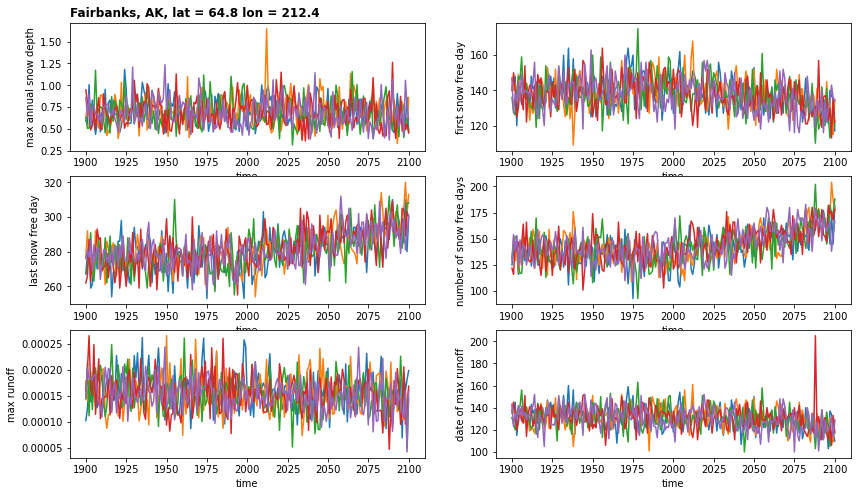

In [52]:
# look at first ~5 years of data 
plt.figure(figsize=[14,8])
for i in range(len(sno_vars)):
    plt.subplot(3,2,(i+1))
    dsPTANN[sno_vars[i]].plot(hue='ens',add_legend=False)  ;
    plt.title(" ") ;
    if i == 0: plt.title(site+': lat = '+str(plat)+' lon = '+str(plon), loc='left', fontsize='large', fontweight='bold') 
    

Work computing time of emergce for chagnes in the 'vernal window', 
- below dive into changes in snow and soil temperature over time

## Flavio defined ToE as time when 10 year running mean > baseline
#### Here we'll take: 
- 20 year baseline (1900-2019)
- 10 year running mean

<xarray.Dataset>
Dimensions:      (lat: 66, lon: 288)
Coordinates:
  * lon          (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat          (lat) float32 23.09 24.03 24.97 25.92 ... 82.46 83.4 84.35
Data variables:
    MaxSnow      (lat, lon) float32 dask.array<chunksize=(66, 288), meta=np.ndarray>
    MaxQrun      (lat, lon) float32 dask.array<chunksize=(66, 288), meta=np.ndarray>
    MaxQrunDate  (lat, lon) float64 dask.array<chunksize=(66, 288), meta=np.ndarray>
    LastSnow     (lat, lon) float64 dask.array<chunksize=(66, 288), meta=np.ndarray>
    FirstSnow    (lat, lon) float64 dask.array<chunksize=(66, 288), meta=np.ndarray>
    SnowFree     (lat, lon) float64 dask.array<chunksize=(66, 288), meta=np.ndarray>
 
<xarray.Dataset>
Dimensions:      (lat: 66, lon: 288, time: 201)
Coordinates:
  * time         (time) int64 1900 1901 1902 1903 1904 ... 2097 2098 2099 2100
  * lon          (lon) float32 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * lat   

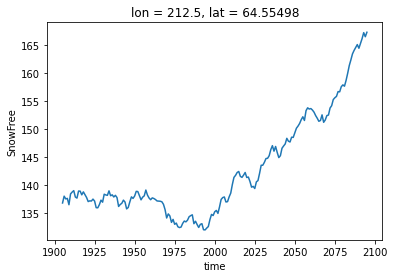

In [84]:
dsBase = ds_ensMean.isel(time=slice(0,30)).mean(dim='time')
print(dsBase)
print(" ")
# do you take ensemble mean over years, and then 10 year rolling mean?
roll_ensMean = ds_ensMean.chunk({"time": 201}).rolling(time=11, center=True).mean(dim='time')
print(roll_ensMean)
roll_ensMean.SnowFree.sel(lat = plat, lon = plon, method='nearest').plot(hue='ens',add_legend=False) ;

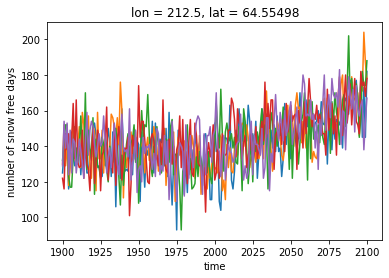

In [82]:
dsANN.SnowFree.sel(lat = plat, lon = plon, method='nearest').plot(hue='ens',add_legend=False) ;